In [67]:
import pandas as pd
from catboost import Pool, CatBoostClassifier
import shap

import sklearn.metrics as m
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# import pandas_profiling
import spacy
import ru_core_news_sm
nlp = spacy.load('ru_core_news_sm')

`import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.


In [2]:
try:
    df = pd.read_excel('/Users/anshilina/Downloads/patients_data.xlsx')
except:
    df = pd.read_csv('cld.csv')

In [70]:
# pandas_profiling.ProfileReport(df)

In [4]:
df.columns = ['admittion', 'discharge', 'sex', 'height', 'weight', 'BMI', 'BSA', 'birth',
              'age', 'opertatzii', 'before_op', 'redo', 'diag', 'mkb', 'soput',
              'medic_osn', 'medic', 'eho', 'ekg', 'akg', 'kt', 'first_op',
              'op_date', 'DateOfOper', 'target']
df['id'] = df.index

df['redo'] = df['redo'].fillna(0)
#df = df.fillna('')

In [5]:
df.tail(2)

,admittion,discharge,sex,height,weight,BMI,BSA,birth,age,opertatzii,...,medic,eho,ekg,akg,kt,first_op,op_date,DateOfOper,target,id
298,2017-07-27,2017-08-11,m,65,6.80,84.34,0.35,12.01.2017,202,02.08.2017: (Откр./ИК) Перевязка ранее наложен...,...,"аспирин-кардио, дигоксин, панангин, элькар, ви...","ЭхоКГ ВПС (27.07.2017 13:46:33, Г.)\nЛЖ, ЛП:...",ЭКГ (27.07.2017 15:58:11)\nРитм сердца синусов...,АКГ ВПС (28.07.2017 13:35:25): Заключение: Дво...,NaN,Перевязка ранее наложенного анастомоза по Blal...,02.08.2017 9:50:30,2017-08-02,0,298
299,2017-05-11,2017-05-22,f,64,5.42,67.75,0.31,06.12.2016,160,15.05.2017: (Откр./ИК) Пластика дефекта межжел...,...,"аспаркам, верошпирон, дигоксин","от 27.04.2017 Левое предсердие, левый желудоче...","от 11.05.2017 Ритм правильный, синусовый, ЭОс ...",NaN,NaN,Пластика дефекта межжелудочковой перегородки к...,15.05.2017 8:40:00,2017-05-15,0,299


_______________________

____________
# EHO part

In [6]:
eho = df[['id', 'eho']].copy()

In [7]:
eho['eho'] = eho['eho'].str.lower()

In [8]:
eho['eho_'] = eho['eho'].str.extract(r'заключение:? ?(.*?)$').fillna(' ').astype('str')

In [9]:
res = pd.Series(eho['eho_'].sum().split(' ')).value_counts() 
res[res > 20]

                   86
увеличение         62
стеноз             57
отделов            51
дмжп,              46
гипоплазия         44
с                  39
правых             36
в                  35
ла,                33
мм                 31
мпс,               30
ла                 28
на                 28
оап,               28
ооо,               27
клапанный          25
левых              25
п/о                25
и                  24
легочной           23
аорты,             22
функционирующий    22
dtype: int64

In [10]:
eho_list = ['стеноз', 'гипопла', 'мпс', 'ооо', 'оап', 'дмжп', 'анастомоз']

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий</b></font>
   
Чтобы не писать от руки можно получить самые популярные слова через `res[res > 20].index.values`.

</div>

<div class="alert alert-info">
Это ж не оно. "Интеллектуально" ручками выбрано подходящее на мой взгляд. Не топ 20 :)
</div>

In [11]:
for col in eho_list:
    eho[col] = eho['eho'].str.contains(col, na=False).astype('int')

In [12]:
eho = eho[['id', *eho_list]].fillna(0)

In [13]:
eho

,id,стеноз,гипопла,мпс,ооо,оап,дмжп,анастомоз
0,0,0,0,0,1,0,1,1
1,1,1,1,1,1,1,1,0
2,2,0,0,0,0,1,1,1
3,3,1,1,1,1,0,1,1
4,4,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
295,295,0,0,0,1,1,0,0
296,296,0,0,1,0,0,1,0
297,297,1,1,0,0,1,1,0
298,298,1,1,0,0,0,1,1


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий</b></font>
   
Хороший подход к тому, чтобы вытащить самые популярные заключения по эхо и закодировать их! Возможно стоим почистить предложения перет тем, как смотреть частоту встречаемости слов: убрать "," через re, лемматизировать слова (см. Mystem()), а также можно исключить стоп-слова (предлоги). Тогда это сработает еще лучше.

</div>

<div class="alert alert-info">
Можно, конечно, но зачем? Я ж сама выбираю нужное, просто на основе топа. Запятым пофиг, оно все пропадет само. 
</div>

________________________________
## MKB part

In [14]:
mkb = df[['id', 'mkb']]

In [15]:
mkb['mkb'] = mkb['mkb'].str.split(',')
mkb = mkb.explode('mkb')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий</b></font>

За `explode` спасибо! Не знала, что можно вот так вот схлопнуть строку)

</div>

In [16]:
mkb['mkb'] = mkb['mkb'].str.replace('Q','',regex=True).str.strip().astype('str')

In [17]:
mkb_list = mkb['mkb'].value_counts()
mkb_list = mkb_list[mkb_list > 2].index.to_list()

In [18]:
mkb.loc[~mkb['mkb'].isin(mkb_list),'mkb'] = 'Oth'

In [19]:
mkb['val'] = 1

In [20]:
mkb = mkb.pivot_table(columns='mkb', index='id', values='val').reset_index().fillna(0).astype('int')

__________________________
## Drugs part

In [21]:
medic = df[['id', 'medic_osn','medic']]

In [22]:
medic = medic.fillna('')

In [23]:
medic['medic_osn'] += ' ' + medic['medic']

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий</b></font>

В некоторых случаях дополнитеных таблеток не прописывают (там пропуск). Объединяя эти столбцы, мы не упускаем этот кусок информации?

</div>

<div class="alert alert-info">
Был стоблец разницы, не влиял. Самоубился.

</div>

In [24]:
medic['medic_osn'] = medic['medic_osn'].str.replace(r'[^а-яА-Я -]', ' ', regex=True) \
                                       .str.replace(' +', ' ', regex=True).str.lower().str.strip()

In [25]:
# drugs = medic['medic_osn'].map(lambda x: set(x.split(' '))).explode().value_counts()

In [26]:
drugs = set(['верошпирон', 'дигоксин', 'фуросемид', 'аспаркам', 'капотен', 'элькар',
         'панангин', 'аспирин', 'вазапростан', 'анаприлин', 'допамин', 'адреналин',
         'аспирин-кардио','мочегонные', 'алпростан', 'гепарин',
         'ампициллин', 'нанипрус', 'траклир', 'гентамицин'])

In [27]:
medic['medic_osn'] = medic['medic_osn'].map(lambda x: set(x.split(' ')) & drugs)

In [28]:
medic = medic.explode('medic_osn')

In [29]:
medic_table = medic.pivot_table(index='id', columns='medic_osn', aggfunc='count', values='medic_osn').reset_index().fillna(0)

In [30]:
medic_table.columns = ['id', *(f'drug_{i}' for i, _ in enumerate(medic_table.columns[1:]))]

__________________________
## EKG part

In [31]:
ekg = df[['ekg','id']].copy()
ekg = ekg.dropna()
ekg['ekg'] = ekg['ekg'].str.lower()

In [32]:
# дата, синусовый
ekg['ekg_date'] = ekg['ekg'].str.extract(r'(\d+\.\d+\.\d{2,4})')
ekg['ekg_sinus'] = ekg['ekg'].str.extract(r'( синус)').notna().astype('int')

In [33]:
# ЧСС 
list_of_ss = '|'.join(['чсс', 'сердцебиений в минуту', 'сердечных сокращений'])
res = ekg['ekg'].str.extract(f'({list_of_ss}) ?=?-? ?(\d+)')
ekg['ekg_ss'] = res[1]

In [34]:
# эос
eos_dict = {'прав': 1,
            'лев': 2,
            'норм':3, 
            'гориз':4, 
            'верт':5}

def ekg_replace(data):
    res = [eos_dict.get(x) for x in eos_dict.keys() if x in data]
    if res:
        return res[0]
    return 0

list_of_eos = '|'.join(['эос', 'электрической оси сердца:', 'ось сердца', 'ось'])
res = ekg['ekg'].str.extract(f'(({list_of_eos}) (отклонена)? ?(\w+))|((\w+) (положение э))')
res[3] = res[3].fillna(res[5])
ekg['ekg_eos'] = res[3]
ekg['ekg_eos'] = ekg['ekg_eos'].fillna(' ')
ekg['ekg_eos'] = ekg['ekg_eos'].map(ekg_replace)

In [35]:
ekg['ekg_qrs'] = ekg['ekg'].str.extract('(qrs) ?=? ?(\d(,|\.)\d+)')[1].str.replace(',','.', regex=True).astype('float')
ekg['ekg_qrst'] = ekg['ekg'].str.extract('(qrst) ?=? ?(\d(,|\.)\d+)')[1].str.replace(',','.', regex=True).astype('float')
ekg['ekg_pq'] = ekg['ekg'].str.extract('(pq) ?=? ?(\d(,|\.)\d+)')[1].str.replace(',','.', regex=True).astype('float')

In [36]:
#ekg['ekg_clr'] = ekg['ekg'].str.lower().str.replace(r'[^а-я ]', ' ', regex=True)
#ekg['ekg_clr'] = ekg['ekg_clr'].str.replace(r'\b\w{,3}\b',' ',regex=True).str.replace(r' +',' ', regex=True).str.strip()

In [37]:
ekg = ekg.fillna(0).drop('ekg', axis=1)
ekg.head(2)

,id,ekg_date,ekg_sinus,ekg_ss,ekg_eos,ekg_qrs,ekg_qrst,ekg_pq
0,0,02.12.2016,1,120,1,0.07,0.26,0.12
1,1,13.01.2017,1,122,3,0.06,0.00,0.12


In [38]:
# ekg['ekg_pq'].value_counts()
# ekg['ekg_qrst'].value_counts()
# ekg['ekg_qrs'].value_counts()

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий</b></font>

Круто, что получилось достать информацию из текста. Почему то в некоторых диагнозах не было показателей `ekg_pq`, `ekg_qrst`, `ekg_qrs`, много нулей.

</div>

In [39]:
# qq = ekg[['ekg_date','id']].copy()
# qq['new_date'] = pd.to_datetime(ekg['ekg_date'])
# qq['op_d'] = pd.to_datetime(df['DateOfOper'])
# qq['new_date'] = qq['new_date'].fillna(qq['op_d'])
# qq['diff'] = (qq['op_d'] - qq['new_date']).dt.days
# qq['diff'].value_counts()

________________________________
## Opertatzii

In [40]:
opr = df[['id', 'first_op','target']].copy()
opr = opr.dropna()
opr['first_op'] = opr['first_op'].str.lower() \
                                 .str.replace('\.',' ', regex=True)\
                                 .str.replace('[^a-zа-я ]','',regex=True)

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий</b></font>

Не работает.

</div>

<div class="alert alert-info">
А это из-за того, что регламента нет, как и файлика реквайрментов.  <br>
Если оно не установлено или разные версии, то и работать не будет. Логично, чо.  <br>
Тут спайси живет. Субъективно оно лучше мистема.    
</div>

In [41]:
opr['first_op'] = opr['first_op'].apply(lambda x: ' '.join([w.lemma_ for w in nlp(x) if not w.is_stop]))

In [42]:
opr['first_op'] 

0      перевязка наложенного анастомоз blalock справа...
1      радикальный коррекция двойной отхождение магис...
2      перевязка наложенного анастомоз blalock c синт...
3      наложение двусторонний кавапульмонального анас...
4      реконструкция путь отток правый желудочек ауто...
                             ...                        
295    радикальный коррекция частично открыть атриове...
296           операция muller суживание лёгочный артерия
297    наложение модифицированный подключичнолегочног...
298    перевязка наложенного анастомоз blalock c синт...
299    пластик дефект межжелудочковый перегородка ксе...
Name: first_op, Length: 300, dtype: object

In [43]:
opr_t = opr[opr['target'] == 1]
opr_t = set(' '.join(opr_t['first_op'].values).split(' '))

In [44]:
opr_r = opr[opr['target'] != 1]
opr_r = set(' '.join(opr_r['first_op'].values).split(' '))

In [45]:
oper_set = opr_t & opr_r

In [46]:
# sum(opr_r['opertatzii'].str.contains('эмболиз'))
# opr_t['opertatzii'].str.contains('эмболиз') 
# opr_r & opr_t
# opr_t - opr_r
# opr_r - opr_t
# qq = opr['opertatzii'].str.replace(r'\(.*\)','', regex=True).str.lower().str.replace(r'[^а-я; ]','',regex=True) \
#.str.replace(' +',' ',regex=True).str.replace('; ',';', regex=True).str.strip().str.split(';')
# qq.explode().value_counts().head(30)

In [47]:
opr['first_op'] = opr['first_op'].map(lambda x: ' '.join(set(x.split(' ')) & oper_set))

In [48]:
opr = opr[['first_op', 'id']]
opr.columns = ['opr', 'id']

_____________________________________
## Merge

In [49]:
df = df.merge(medic_table, on='id', how='left')
df = df.merge(ekg, on='id', how='left')
df = df.merge(mkb, on='id', how='left')
df = df.merge(opr, on='id', how='left')
df = df.merge(eho, on='id', how='left')

In [50]:
#df['ekg_eos'] = df['ekg_eos'].fillna(' ')
#df['ekg_clr'] = df['ekg_clr'].fillna(' ').astype('str')
#df['first_op'] = df['first_op'].fillna(' ').astype('str')
df['opr'] = df['opr'].fillna(' ').astype('str')

In [51]:
df = df.fillna(0)

In [52]:
cols = ['drug_0', 'drug_1', 'drug_2', 'drug_3', 'drug_4', 'drug_5', 'drug_6', 'drug_7', 'drug_8', 'drug_9',
 'drug_10', 'drug_11', 'drug_12', 'drug_13', 'drug_14', 'drug_15', 'drug_16', 'drug_17', 'drug_18', 'drug_19']

text_features = []#['opr']
cat_features = ['redo', 'sex', 'ekg_eos', 'ekg_sinus']

In [53]:
df[cols] = df[cols].fillna(0).astype('int')
df[cat_features] = df[cat_features].astype('str')

In [54]:
test_df = df[['sex','height','weight','BMI','BSA','age','target', 'redo', 'ekg_ss', 'ekg_sinus',
              'ekg_eos','ekg_qrs','ekg_qrst','ekg_pq', *mkb_list,  *cols]]

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий</b></font>

Нужен корелляционный анализ: 'ekg_ss', 'ekg_sinus', 'ekg_eos','ekg_qrs','ekg_qrst','ekg_pq' должны быть по идее скореллированы. Может, поэтому линейный классификатор не справляется.
</div>

<div class="alert alert-info">
Если линейный не справляется, то он про это пишет :) Он добрый.  По факту корреляция влияет только на интерпретацию, в остальном пофиг, не критично. Полный анализ висит в самом начале, # pandas_profiling.ProfileReport(df) вот эта вот строка. В комментариях дабы не мешалось просто так, у него слишком объемный вывод.
</div>

In [55]:
567567

567567

In [56]:
train, test = train_test_split(test_df, test_size=0.4, random_state=2, stratify=test_df['target'])



train_pool = Pool(train.drop('target', axis=1), 
                 train['target'],
                 cat_features=cat_features,
                 text_features=text_features)

valid_pool = Pool(test.drop('target', axis=1), 
                 test['target'],
                 cat_features=cat_features,
                 text_features=text_features)
model = CatBoostClassifier(random_seed=42, verbose=250, eval_metric='Recall', eta=0.5, iterations=500,
                          auto_class_weights='Balanced'
                          )
model.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0000000	test: 0.1666667	best: 0.1666667 (0)	total: 98.6ms	remaining: 49.2s
250:	learn: 1.0000000	test: 0.0000000	best: 0.1666667 (0)	total: 1.68s	remaining: 1.67s
499:	learn: 1.0000000	test: 0.0000000	best: 0.1666667 (0)	total: 2.79s	remaining: 0us

bestTest = 0.1666666667
bestIteration = 0

Shrink model to first 1 iterations.


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий</b></font>
    
Подбор параметров?

</div>

<div class="alert alert-info">
Нафига козе баян? Гиперпараметры - последний шаг, когда все более-менее устойчиво. Тем более у меня висит готовая оптуна для этих целей. <br>
Нам стабилизации хоть какой-то добиться сначала надо, метрика летает просто фантастически в зависимости от разбиения. И фичи еще можно вытянуть. Зачем на каждый шаг параметры подбирать, показать, что умеешь?)) Это ж не учебный проект. <br>
  Могу отдельно оптуну закинуть. Куда более адекватный и интеллектуальный подбор параметров, чем стандартные гридсерчи.
</div>

In [57]:
X = test_df.drop(['target'], axis=1)
y = test_df['target']

In [58]:
X.loc[X['redo'] == ' ', 'redo'] = 0

In [59]:
X['redo'] = X['redo'].astype('int')

In [60]:
X_train, X_ts, y_train, y_ts = train_test_split(X,y, test_size=0.3, random_state=1242, stratify=y)

In [61]:
ohe = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
                             # (TfidfVectorizer(), 'opr'),
                              remainder='passthrough')

ords = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),cat_features),
                              (TfidfVectorizer(), 'first_op'),
                              remainder='passthrough')

In [62]:
model = make_pipeline(ohe, 
                     # SMOTE(random_state=42), 
                      LogisticRegression(random_state=42, 
                                         penalty='l2',
                                         solver='liblinear', 
                                         max_iter=400,
                                         class_weight='balanced'
                                        ))

In [63]:
cross_val_score(model, X, y, cv=4, scoring='precision')

array([0.11111111, 0.33333333, 0.33333333, 0.28571429])

TEXT - array([0.14285714, 0.33333333, 0.5       , 0.2       ])  
NOTEXT - array([0.11111111, 0.33333333, 0.33333333, 0.28571429])

In [64]:
X_train, X_ts, y_train, y_ts = train_test_split(X,y, test_size=0.1, stratify=y)
model.fit(X_train, y_train)
m.confusion_matrix(y_ts, model.predict(X_ts))

array([[28,  1],
       [ 1,  0]])

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий</b></font>
    
Почему ты два раза разбиваешь выборку на трейн и тест: отдельно для логистической регрессии, отдельно для катбуста?

</div>

<div class="alert alert-info">
Тут в разбиении рандом стейта нет. Специально. Просто посмотреть конфуз_матрицу на разных разбиениях, что не ездить туда-сюда по ноутбуку. 
</div>

  0%|          | 0/30 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


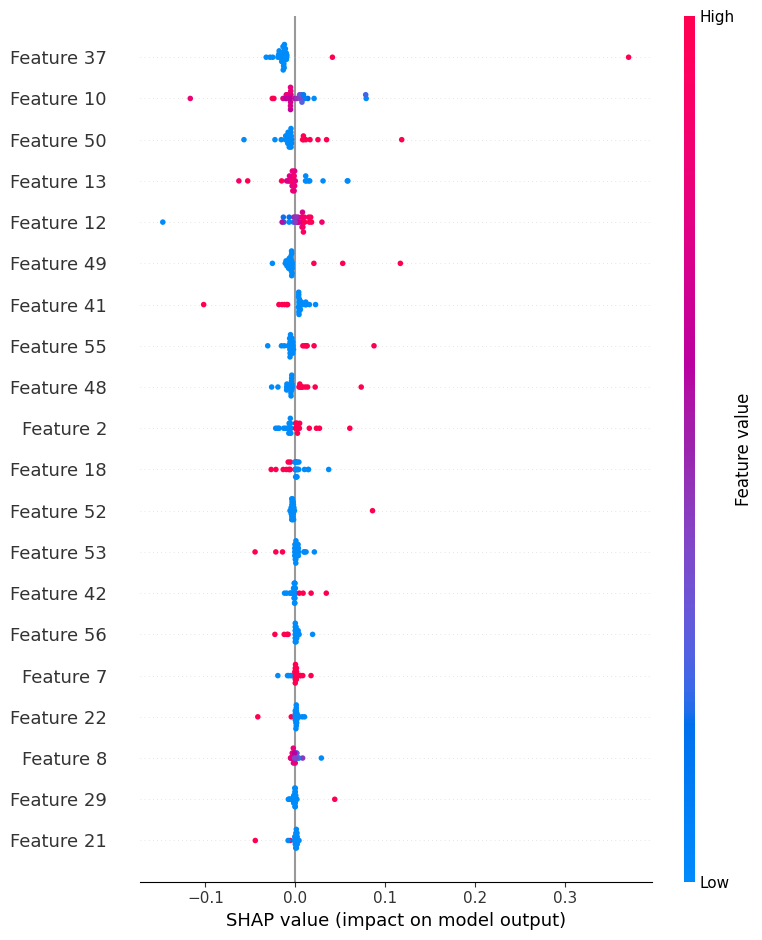

In [65]:
# время
x_Train = model[0].fit_transform(X_ts)
explainer = shap.KernelExplainer(model[1].predict, x_Train)
shap_values = explainer.shap_values(x_Train)
shap.summary_plot(shap_values, x_Train)